<a href="https://colab.research.google.com/github/usama475/Educational-Data-Mining-Student-Performance-Prediction/blob/main/Exploring_Self_Regulated_Learning_and_Student_Performance_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (5000, 23)


,Student_ID,First_Name,Last_Name,Email,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,...,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,S1000,Omar,Williams,student0@university.com,Female,22,Mathematics,97.36,40.61,59.61,...,62.84,59.8865,F,10.3,Yes,No,Master's,Medium,1,5.9
1,S1001,Maria,Brown,student1@university.com,Male,18,Business,97.71,57.27,74.00,...,98.23,81.9170,B,27.1,No,No,High School,Low,4,4.3
2,S1002,Ahmed,Jones,student2@university.com,Male,24,Engineering,99.52,41.84,63.85,...,91.22,67.7170,D,12.4,Yes,No,High School,Low,9,6.1
3,S1003,Omar,Williams,student3@university.com,Female,24,Engineering,90.38,45.65,44.44,...,55.48,51.6535,F,25.5,No,Yes,High School,Low,8,4.9
4,S1004,John,Smith,student4@university.com,Female,23,CS,59.41,53.13,61.77,...,87.43,71.4030,C,13.3,Yes,No,Master's,Medium,6,4.5


Using target column: Final_Score  (task: regression)
R²: 0.8765411134117986
RMSE: 6.15177578172108


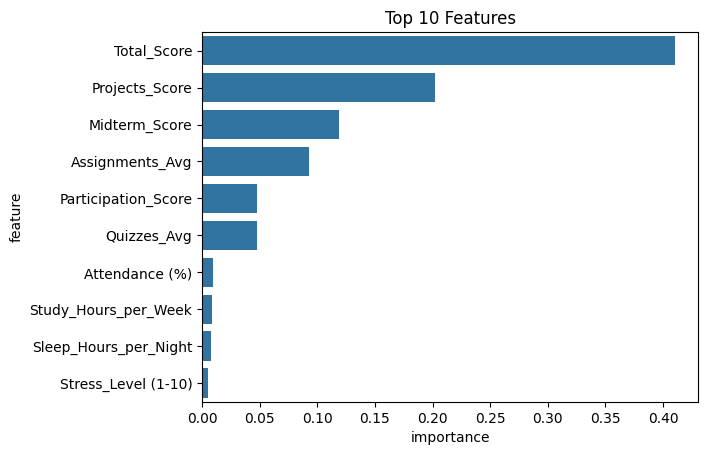

Model saved to /content/model_pipeline.joblib


In [ ]:
# Simplified Colab pipeline (fast version)
!pip install -q openpyxl

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    r2_score, mean_squared_error,
    accuracy_score, precision_score, recall_score, f1_score
)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# === Load dataset ===
file_path = "Student_data.csv"  # Adjust if needed
df = pd.read_csv(file_path)

print("Dataset shape:", df.shape)
display(df.head())

# === Pick target column (set manually if needed) ===
# You can replace with the column you want to predict

# Try to guess the target column (similar to the first cell)
def guess_target_column(df):
    candidates = ['post_test','final_score','grade','score','outcome','label','engagement','srl_score']
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand in cols_lower:
            col = cols_lower[cand]
            ser = df[col].dropna()
            if ser.dtype.kind in 'biu' and ser.nunique() <= 2:
                return col, 'classification'
            if ser.dtype.kind in 'O' and ser.nunique() <= 10:
                return col, 'classification'
            return col, 'regression'
    # fallback: last numeric column
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if num_cols:
        return num_cols[-1], 'regression'
    return df.columns[-1], 'classification'

target_col, task_type = guess_target_column(df)

print(f"Using target column: {target_col}  (task: {task_type})")

y = df[target_col]
X = df.drop(columns=[target_col])

# === Preprocess ===
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('scaler', StandardScaler())]), numeric_cols),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                          ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
    ]
)

# === Model: choose regression or classification ===
if task_type == "regression":
    model = RandomForestRegressor(n_estimators=100, random_state=42)
else:
    model = RandomForestClassifier(n_estimators=100, random_state=42)

pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=y if task_type=='classification' else None
)

# === Train ===
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# === Evaluate ===
if task_type == "regression":
    print("R²:", r2_score(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred))) # Calculate RMSE manually
else:
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1:", f1_score(y_test, y_pred, average='weighted'))

# === Feature importance (fast) ===
model = pipeline.named_steps['model']
if hasattr(model, "feature_importances_"):
    # Get feature names
    ohe = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(categorical_cols) if categorical_cols else []
    feature_names = numeric_cols + list(cat_names)
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    fi = fi.sort_values('importance', ascending=False).head(10)
    sns.barplot(x='importance', y='feature', data=fi)
    plt.title("Top 10 Features")
    plt.show()

# === Save model ===
joblib.dump(pipeline, "/content/model_pipeline.joblib")
print("Model saved to /content/model_pipeline.joblib")

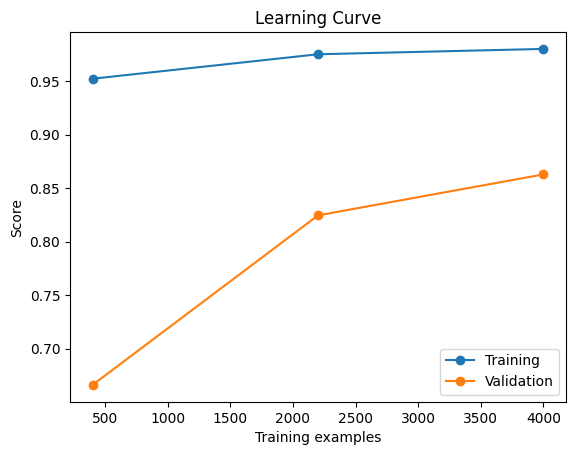

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X, y, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 3),
    scoring="r2" if task_type=="regression" else "accuracy"
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', label="Training")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Validation")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend()
plt.show()

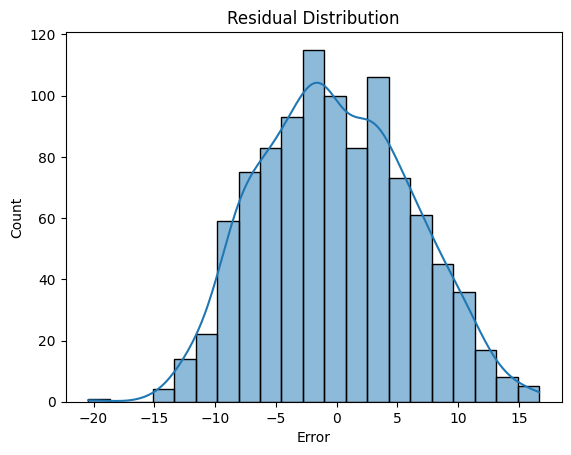

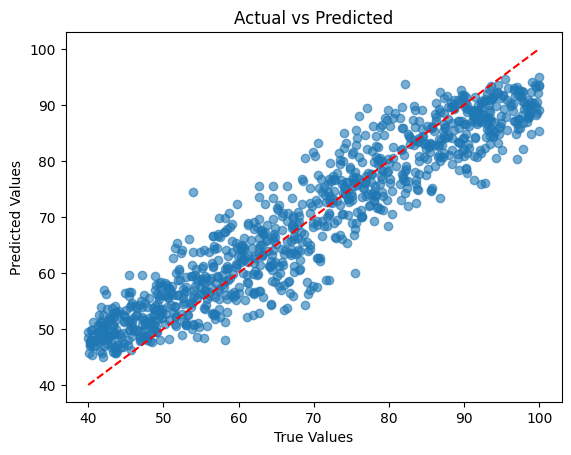

In [ ]:
if task_type == "regression":
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True)
    plt.title("Residual Distribution")
    plt.xlabel("Error")
    plt.show()

    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.show()


In [ ]:
from sklearn.inspection import PartialDependenceDisplay

important_features = fi["feature"].head(2).tolist()  # top 2 features
PartialDependenceDisplay.from_estimator(pipeline, X, important_features)
plt.show()